In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

## The model in theory

We are going to use 4 features: The **price** itself and three extra technical indicators.
- MACD (Trend)
- Stochastics (Momentum)
- Average True Range (Volume)

## Functions

**Exponential Moving Average:** Is a type of infinite impulse response filter that applies weighting factors which decrease exponentially. The weighting for each older datum decreases exponentially, never reaching zero. 
<img src="https://www.bionicturtle.com/images/uploads/WindowsLiveWriterGARCHapproachandExponentialsmoothingEWMA_863image_16.png">

**MACD:**  The Moving Average Convergence/Divergence oscillator (MACD) is one of the simplest and most effective momentum indicators available. The MACD turns two trend-following indicators, moving averages, into a momentum oscillator by subtracting the longer moving average from the shorter moving average.
<img src="http://i68.tinypic.com/289ie1l.png">

**Stochastics oscillator:** The Stochastic Oscillator is a momentum indicator that shows the location of the close relative to the high-low range over a set number of periods.

<img src="http://i66.tinypic.com/2vam3uo.png">

**Average True Range:** Is an indicator to measure the volalitility (NOT price direction). The largest of:
- Method A: Current High less the current Low
- Method B: Current High less the previous Close (absolute value)
- Method C: Current Low less the previous Close (absolute value)

<img src="http://d.stockcharts.com/school/data/media/chart_school/technical_indicators_and_overlays/average_true_range_atr/atr-1-trexam.png" width="400px">

Calculation:
<img src="http://i68.tinypic.com/e0kggi.png">

In [3]:
def MACD(df,period1,period2,periodSignal):
    EMA1 = pd.DataFrame.ewm(df,span=period1).mean()
    EMA2 = pd.DataFrame.ewm(df,span=period2).mean()
    MACD = EMA1-EMA2
    
    Signal = pd.DataFrame.ewm(MACD,periodSignal).mean()
    
    Histogram = MACD-Signal
    
    return Histogram

def stochastics_oscillator(df,period):
    l, h = pd.DataFrame.rolling(df, period).min(), pd.DataFrame.rolling(df, period).max()
    k = 100 * (df - l) / (h - l)
    return k

def ATR(df,period):
    '''
    Method A: Current High less the current Low
    '''
    df['H-L'] = abs(df['High']-df['Low'])
    df['H-PC'] = abs(df['High']-df['Price'].shift(1))
    df['L-PC'] = abs(df['Low']-df['Price'].shift(1))
    TR = df[['H-L','H-PC','L-PC']].max(axis=1)
    return TR.to_frame()

## Read data

In [4]:
df = pd.read_csv('ETHUSD2.csv', nrows=1000000)


#dfPrices = pd.read_csv('ETHUSD.csv', delimiter=',',usecols=[1])
#dfPrices = dfPrices.iloc[::-1]
#dfPrices["Price"] = (dfPrices["Price"].apply(lambda x: float(x[0].replace(',', '')))

In [5]:
#Separate trade price and calculate mid market price
df.rename(columns={"trade_px": "TradePrice"}, inplace=True)
dfPrices= pd.DataFrame()
dfPrices["Price"] = df[["b1", "a1"]].mean(axis=1)
date_time=pd.to_datetime(df.order_date_time).to_frame()


In [6]:
#dfPrices[:-2]
dfPrices.tail(2)

,Price
548723,288.305
548724,288.305


In [7]:
dfPrices.head(2)

,Price
0,290.780
1,290.785


In [8]:
date_time.tail()

,order_date_time
548720,2017-09-19 15:06:43.041518
548721,2017-09-19 15:06:43.041518
548722,2017-09-19 15:06:43.041518
548723,2017-09-19 15:06:43.041518
548724,2017-09-19 15:06:43.041518


In [9]:
date_time_price=date_time.join(dfPrices)
date_time_price.columns = ['Date_Time', 'ETHUSD']
date_time_price.tail()

,Date_Time,ETHUSD
548720,2017-09-19 15:06:43.041518,288.305
548721,2017-09-19 15:06:43.041518,288.305
548722,2017-09-19 15:06:43.041518,288.305
548723,2017-09-19 15:06:43.041518,288.305
548724,2017-09-19 15:06:43.041518,288.305


## Plot

In [10]:
price = dfPrices.iloc[len(dfPrices.index)-60:len(dfPrices.index)].as_matrix().ravel()

### Price

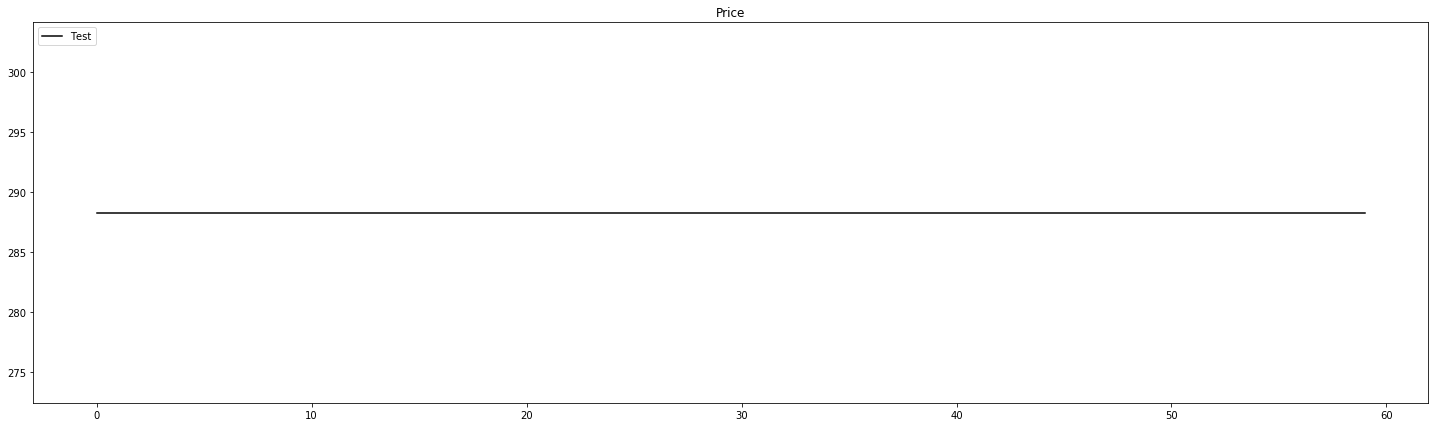

In [11]:
prices = dfPrices.iloc[len(dfPrices.index)-60:len(dfPrices.index)].as_matrix().ravel()
plt.figure(figsize=(25,7))
plt.plot(prices,label='Test',color='black')
plt.title('Price')
plt.legend(loc='upper left')
plt.show()

### MACD

In [12]:
macd = MACD(dfPrices.iloc[len(dfPrices.index)-60:len(dfPrices.index)],4,12,3)

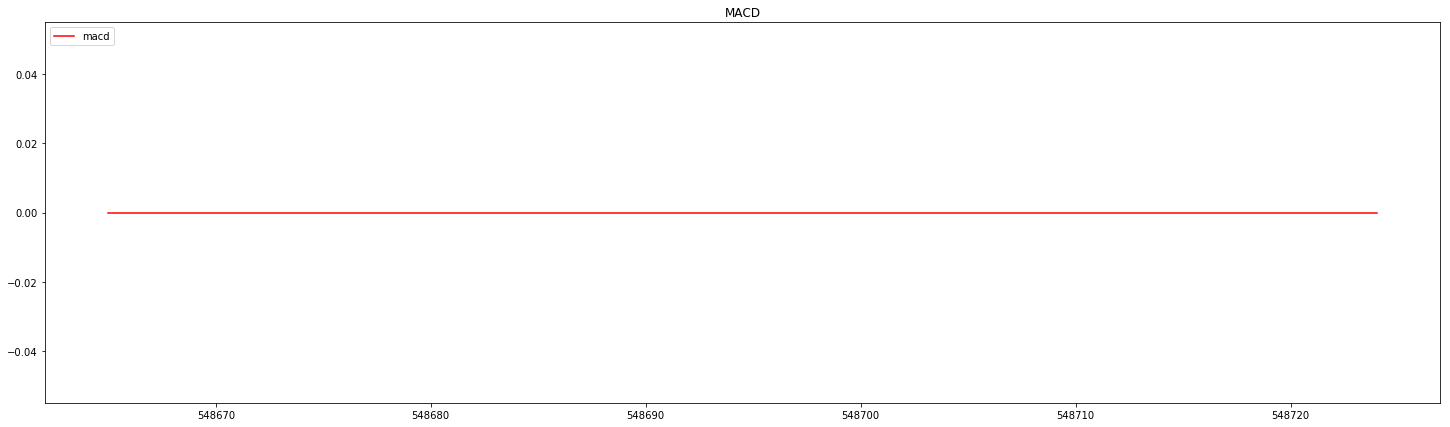

In [13]:
plt.figure(figsize=(25,7))
plt.plot(macd,label='macd',color='red')
plt.title('MACD')
plt.legend(loc='upper left')
plt.show()

### Stochastics Oscillator

In [14]:
stochastics = stochastics_oscillator(dfPrices.iloc[len(dfPrices.index)-60:len(dfPrices.index)],14)

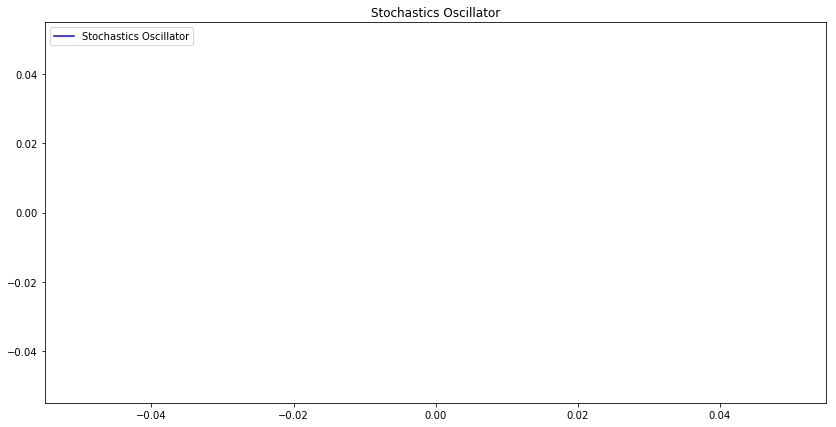

In [15]:
plt.figure(figsize=(14,7))
#First 100 points because it's too dense
plt.plot(stochastics[0:100],label='Stochastics Oscillator',color='blue')
plt.title('Stochastics Oscillator')
plt.legend(loc='upper left')
plt.show()

## Create complete DataFrame & Save Data

In [16]:
#Shift prices a number of rows into the future to create a training dataset
dfPriceShift = dfPrices.shift(-5)
dfPriceShift.rename(columns={'Price':'PriceTarget'}, inplace=True)

In [17]:
dfPriceShift.head(2)

,PriceTarget
0,290.925
1,290.925


In [18]:
macd = MACD(dfPrices,12,26,9)
macd.rename(columns={'Price':'MACD'}, inplace=True)

In [19]:
#stochastics = stochastics_oscillator(dfPrices,14)
#stochastics.rename(columns={'Price':'Stochastics'}, inplace=True)

In [20]:
#atr = ATR(df,14)
#atr.rename(columns={0:'ATR'}, inplace=True)

In [21]:
df["bbq1"]=df["b1"].multiply(df["bq1"], axis="index")
df["aaq1"]=df["a1"].multiply(df["aq1"], axis="index")
df["Spread"]=df["a1"]-df["b1"]
df.head()

,id,TradePrice,trade_volume,b1,b2,b3,b4,b5,b6,b7,...,aq27,aq28,aq29,aq30,order_date_time,trades_date_time,update_type,bbq1,aaq1,Spread
0,2,0.00,0.000000,290.64,290.61,290.60,290.51,290.50,290.49,290.38,...,8.0119,11.300000,31.744415,0.010389,20170918 06:42:13.830687,20000101 00:00:00.000000,1,8.71920,87654.196000,0.28
1,4,0.00,0.000000,290.63,290.60,290.51,290.50,290.49,290.38,290.33,...,0.1110,8.011900,11.300000,31.744415,20170918 06:42:15.283817,20000101 00:00:00.000000,1,9073.46860,1275.342182,0.31
2,5,290.93,0.286487,290.63,290.60,290.51,290.50,290.49,290.38,290.33,...,0.1110,8.011900,11.300000,31.744415,20170918 06:42:15.283817,20170918 06:42:15.877565,2,9073.46860,1275.342182,0.31
3,6,290.93,0.286487,290.94,290.62,290.60,290.51,290.50,290.49,290.48,...,0.1110,8.011900,11.300000,31.744415,20170918 06:42:16.658818,20170918 06:42:15.877565,1,6223.20660,126.563250,0.01
4,8,290.93,0.286487,290.92,290.67,290.66,290.63,290.60,290.53,290.50,...,0.0589,5.496297,0.111000,8.011900,20170918 06:42:18.174597,20170918 06:42:15.877565,1,6574.50108,72.732500,0.01


In [22]:

vol = df["trade_volume"]
TradePrice = df["TradePrice"]

b1 = df["b1"]
b2 = df["b2"]
b3 = df["b3"]
b4 = df["b4"]
b5 = df["b5"]
b6 = df["b6"]
b7 = df["b7"]
b8 = df["b8"]
b9 = df["b9"]
b10 = df["b10"]
a1 = df["a1"]
a2 = df["a2"]
a3 = df["a3"]
a4 = df["a4"]
a5 = df["a5"]
a6 = df["a6"]
a7 = df["a7"]
a8 = df["a8"]
a9 = df["a9"]
a10 = df["a10"]

bq1 = df["bq1"]
bq2 = df["bq2"]
bq3 = df["bq3"]
bq4 = df["bq4"]
bq5 = df["bq5"]
bq6 = df["bq6"]
bq7 = df["bq7"]
bq8 = df["bq8"]
bq9 = df["bq9"]
bq10 = df["bq10"]
aq1 = df["aq1"]
aq2 = df["aq2"]
aq3 = df["aq3"]
aq4 = df["aq4"]
aq5 = df["aq5"]
aq6 = df["aq6"]
aq7 = df["aq7"]
aq8 = df["aq8"]
aq9 = df["aq9"]
aq10 = df["aq10"]

bbq1 = df["bbq1"]
aaq1 = df["aaq1"]
Spread = df["Spread"]
datetime = df["trades_date_time"]

#FIX THIS. Should it be trades or order date time?

In [23]:
final_data = pd.concat([dfPrices, dfPriceShift, macd,TradePrice, vol,b1,a1, bq1, aq1, Spread], axis=1)
backtrader_data= pd.concat([datetime, TradePrice, vol], axis=1)
# b1, b2, b3, b4, b5, b6, b7, b8, b9, b10,
# a1, a2, a3, a4, a5, a6, a7, a8, a9, a10,
# bq1,bq2,bq3,bq4,bq5,bq6,bq7,bq8,bq9,bq10, 
#  aq1, aq2, aq3, aq4, aq5, aq6, aq7, aq8, aq9, aq10, 
# Delete the entries with missing values (where the stochastics couldn't be computed yet) because have a lot of datapoints ;)
#final_data = final_data.dropna()



In [24]:
final_data.head()

,Price,PriceTarget,MACD,TradePrice,trade_volume,b1,a1,bq1,aq1,Spread
0,290.780,290.925,0.000000,0.00,0.000000,290.64,290.92,0.030,301.300000,0.28
1,290.785,290.925,0.000053,0.00,0.000000,290.63,290.94,31.220,4.383523,0.31
2,290.785,290.770,0.000053,290.93,0.286487,290.63,290.94,31.220,4.383523,0.31
3,290.945,290.770,0.004142,290.93,0.286487,290.94,290.95,21.390,0.435000,0.01
4,290.925,290.770,0.004811,290.93,0.286487,290.92,290.93,22.599,0.250000,0.01


In [25]:
#backtrader_data=backtrader_data.drop_duplicates(['TradePrice'])
backtrader_data['open']= backtrader_data['TradePrice']
backtrader_data['high']= backtrader_data['TradePrice']
backtrader_data['low']= backtrader_data['TradePrice']
backtrader_data['close']= backtrader_data['TradePrice']
backtrader_data = backtrader_data[['trades_date_time', 'TradePrice', 'open', 'high', 'low', 'close', 'trade_volume']]
#date_time=pd.to_datetime(backtrader_data.trades_date_time, format="%Y%m%d %H:%M:%S.%f").to_frame()
backtrader_data = backtrader_data.drop(backtrader_data.index[0])
backtrader_data.head()


,trades_date_time,TradePrice,open,high,low,close,trade_volume
1,20000101 00:00:00.000000,0.00,0.00,0.00,0.00,0.00,0.000000
2,20170918 06:42:15.877565,290.93,290.93,290.93,290.93,290.93,0.286487
3,20170918 06:42:15.877565,290.93,290.93,290.93,290.93,290.93,0.286487
4,20170918 06:42:15.877565,290.93,290.93,290.93,290.93,290.93,0.286487
5,20170918 06:42:18.252739,290.66,290.66,290.66,290.66,290.66,0.030000


In [26]:
final_data.to_csv('ETHUSD_TechnicalIndicators.csv',index=False)

In [27]:
#backtrader_data.to_csv('ETHUSD_backtrader.csv', date_format='%Y-%m-%d %H:%M:%S.%f', index=False)

In [28]:
backtrader_data.to_csv('ETHUSD_backtrader.csv',index=False)